# <div align="center">**Table of Contents**
1. [<span style="color:blue">About This Dataset](#1)<br>
2. [<span style="color:blue">Import Libraries](#2)<br>
3. [<span style="color:blue">Load Data](#3)<br>
4. [<span style="color:blue">Data analysis](#4)<br>
    4.1 [DEATH_EVENT](#5)<br>
    4.2 [Nominal variables](#6)<br>
    4.3 [Numerical variables](#7)<br>
    4.4 [Bivariate Analysis](#8)<br>
5. [<span style="color:blue">Data preparation](#9)<br>
6. [<span style="color:blue">Logistic Regression from scratch](#10)<br>
    6.1 [Baseline model](#11)<br>
    6.2 [Feature Engineering](#12)<br>
    6.3 [New Features](#13)<br>
7. [<span style="color:blue">Summary](#14)<br>

    
 
    
    

# <span style="color:blue"><div align="center">**About This Dataset** <a  name="1"></a>

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.<br>

#### <span style="color:blue">  **Columns**
    
>**age** <br>
>**anaemia**  _Decrease of red blood cells or hemoglobin (boolean)_ <br> 
>**creatinine_phosphokinase** _Level of the CPK enzyme in the blood (mcg/L)_ <br>
>**diabetes**  _If the patient has diabetes (boolean)_ <br>
>**ejection_fraction** _Percentage of blood leaving the heart at each contraction (percentage)_ <br>
>**high_blood_pressure** _If the patient has hypertension (boolean)_ <br>
>**platelets** _Platelets in the blood (kiloplatelets/mL)_ <br>
>**serum_creatinine** _Level of serum creatinine in the blood (mg/dL)_ <br>
>**serum_sodium** _Level of serum sodium in the blood (mEq/L)_ <br>
>**sex** _Woman or man (binary)_ <br>
>**smoking** _If the patient smokes or not (boolean)_ <br>
>**time** _Follow-up period (days)_ <br>
>**DEATH_EVENT** _If the patient deceased during the follow-up period (boolean)_ <br>
#### <span style="color:blue">  **Source** https://www.kaggle.com/andrewmvd/heart-failure-clinical-data 

# <span style="color:blue"><div align="center">**Import Libraries** <a  name="2"></a>

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
%matplotlib inline
np.random.seed(1)

# <span style="color:blue"><div align="center">**Load Data** <a  name="3"></a>

In [ ]:
df = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")

print('data shape', df.shape)

df.head()

In [ ]:
df['DEATH_EVENT'].value_counts()

# <span style="color:blue"><div align="center">**Data analysis** <a  name="4"></a>

> Let us first review the general information of the data 

In [ ]:
df.info()

As you can see the data types are int and float so we do not need to convert them into categorical variables

In [ ]:
df.describe()

> check for null values in the data

In [ ]:
df.isna().sum()

As we see, there are no **null** values and we don't need to drop them out or fill by mean value or something like that, this technique is called handling missing value, but we will not use it now. so we can continue

### **DEATH_EVENT** <a  name="5"></a>
>lets see Deat Event distribution

In [ ]:
f, ax  = plt.subplots(1,2,figsize = (18,6))
sns.countplot(df['DEATH_EVENT'],ax=ax[0],palette = 'bright',alpha=0.7)

count = df['DEATH_EVENT'].value_counts(normalize=True)
count.plot.pie(autopct="%.2f%%",explode = [0,0.2],ax=ax[1])
plt.show()

As we see it, the death rate is twice as low, so we will need to treat the imbalance. which we can with two ways:
1. preproccess data
2. come up with appropriate metric

### **Nominal variables** <a  name="6"></a>
> Lets see distribution of **anaemia, diabetes, high_blood_pressure, sex, smoking**

In [ ]:
plt.figure(1,figsize=(20,20))
plt.subplot(321)
df['anaemia'].value_counts().plot.pie(title='% distribution of anaemia',explode=[0,.1],autopct="%1.1f")

plt.subplot(322)
df['diabetes'].value_counts().plot.pie(title='% distribution of diabetes',explode=[0,.1],autopct="%1.1f")

plt.subplot(323)
df['high_blood_pressure'].value_counts().plot.pie(title='% distribution of high_blood_pressure',explode=[0,.1],autopct="%1.1f")

plt.subplot(324)
df['sex'].value_counts().plot.pie(title='% distribution of sex',explode=[0,.1],autopct="%1.1f")

plt.subplot(325)
df['smoking'].value_counts().plot.pie(title='% distribution of smoking',explode=[0,.1],autopct="%1.1f")
plt.show()

from these plots we can determine that:<br>
- most of our patients are men<br>
- people who don't smoke<br>
- haven't high_blood_pressure<br>
- haven't diabetes <br>
- haven't anaemia<br>

### **Numerical variables** <a  name="7"></a>
> Lets see distribution of **age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, time**<br>
> In these visualizations I will use the plotly library because we have numerical variables and we may need to see the values on the graph

> helper function for plotting

In [ ]:
def createPlot(data, col:str, ttext:str, xtext:str, ytext:str) ->None:
    """
    this function creates histogram and boxplot by pyplot library and also count skewness
    
    Arguments:
    data -- pandas dataframe
    col -- column name which we want to plot
    ttext -- string which we want to write on top of the graph
    xtext -- string which we want to write on x axis
    ytext -- string which we want to write on y axis
    
    Returns:
    None
    """
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Histogram(x=data[col],marker_color='#6a6fff'),row=1,col=1)
    fig.add_trace(go.Box(x=data[col]),row=1,col=2)
    
    fig.update_layout(
        title_text=ttext,
        xaxis_title_text=xtext,
        yaxis_title_text=ytext, 
        bargap=0.05, 
        template = 'plotly_dark',
        width=900, height=600
    )
    fig.add_annotation(dict(font=dict(color='yellow',size=15),
                                        x=0.35,
                                        y=1.1,
                                        showarrow=False,
                                        text="Skewness = "+str(df[col].skew()),
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
    
    fig.show()

>lets see age distribution

In [ ]:
createPlot(df,"age","Age distribution","Age","count")

as we see there is some important things which we should mention
- Aplicant age is left skewed (0.42).
- Not many outliers.
- Most of the applicant's age is near a range of 60.

>lets check Creatinine Phosphokinase Distribution

In [ ]:
createPlot(df,"creatinine_phosphokinase","Creatinine Phosphokinase Distribution","creatinine_phosphokinase","count")

- Creatinine_phosphokinase is left skewed (4.46).
- Many outliers are present in the distribution.
- Most of the applicant's creatinine_phosphokinase is near a range of 250.

In [ ]:
createPlot(df,"ejection_fraction","Ejection Fraction Distribution","Ejection fraction (%)","count")

- ejection_fraction is left skewed (0.5).
- Not many outliers.
- Most of the applicant's ejection_fraction is near a range of 38.

In [ ]:
createPlot(df,"platelets","Platelets Distribution","Platelets Distribution","count")

- platelets is left skewed (1.46).
- Many outliers are present in the distribution.
- Most of the applicant's Platelets Distribution is near a range of 262k.

In [ ]:
createPlot(df,"serum_creatinine","Serum Creatinine Distribution","Serum Creatinine(mg/dL)","count")

- serum_creatinine is left skewed (4.45).
- Many outliers are present in the distribution.
- Most of the applicant's serum_creatinine is near a range of 1.1.

In [ ]:
createPlot(df,"serum_sodium","Serum Sodium Distribution","Serum Sodium (mEq/L)","count")

- serum_sodium is right skewed (1.04).
- there are a little bit outliers in the distribution.
- Most of the applicant's serum_sodium is near a range of 137.

In [ ]:
createPlot(df,"time","Time Distribution","Time (days)","count")

- time is left skewed (0.12).
- Many outliers are present in the distribution.
- Most of the applicant's Time Distribution is near a range of 115.

# <span style="color:blue"><div align="center">**Bivariate Analysis** <a  name="8"></a>

>firstly let's plot the correlation matrix which will give us a whole picture of the feature dependencies of our target

In [ ]:
matrix = df.corr()
f, ax = plt.subplots(figsize=(12, 6))
with sns.axes_style("white"):
    sns.heatmap(matrix,mask=np.triu(matrix,1),annot=True,fmt=".2f", vmax=.8,cbar=False,cmap="coolwarm");

we notice that there is some features which is not correlated to output variable, we will check this hyphotesis below

In [ ]:
plt.figure(figsize=(14, 14)) 
sns.pairplot(df.drop(columns=['DEATH_EVENT','anaemia','sex','time','high_blood_pressure','diabetes','smoking']), diag_kind='kde');

from this dependept plots we can determine some key things<br>
for example when creatinine_phosphokinase increases serum_creatinine decreases

> lets plot the relationship between each variable regarding "DEATH_EVENT" <br>
first consider categorical variables, so I separate data by categorical and numerical variable<a  name="15">

In [ ]:
catVariable = ["anaemia","diabetes","high_blood_pressure","sex","smoking"]
numVariable = list(set(df.columns.drop("DEATH_EVENT"))-set(catVariable))

In [ ]:
f, ax  = plt.subplots(3,2,figsize = (15,15))
cross = pd.crosstab(df[catVariable[0]],df['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[0][0],title =catVariable[0])

cross = pd.crosstab(df[catVariable[1]],df['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[0][1],title =catVariable[1])

cross = pd.crosstab(df[catVariable[2]],df['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[1][0],title =catVariable[2])

cross = pd.crosstab(df[catVariable[3]],df['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[1][1],title =catVariable[3])

cross = pd.crosstab(df[catVariable[4]],df['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[2][0],title =catVariable[4])
plt.show()

There was no significant pattern observed based on the above feautres. <br> 
It can be inferred that this features does not much impact for death

> now we need to plot relationship between numerical variable and "DEATH_EVENT", but before we do this, we need to transform variable to categorical. we separate them with three class low Medium and High value of number. so we write helper function get_categories which Assign variable to the appropriate class and we apply this function all variable columns.

In [ ]:
groups = ['Low','Medium','High']
dfForPlot = df.copy();
def get_categories(x):
    if x < q1:
        return groups[0]
    elif x < q3:
        return groups[1]
    else:
        return groups[2]    

for col in numVariable:
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)
    dfForPlot[col] = df[col].apply(get_categories)

In [ ]:
f, ax  = plt.subplots(4,2,figsize = (22,22))
cross = pd.crosstab(dfForPlot[numVariable[0]],dfForPlot['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[0][0],title =numVariable[0])

cross = pd.crosstab(dfForPlot[numVariable[1]],dfForPlot['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[0][1],title =numVariable[1])

cross = pd.crosstab(dfForPlot[numVariable[2]],dfForPlot['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[1][0],title =numVariable[2])

cross = pd.crosstab(dfForPlot[numVariable[3]],dfForPlot['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[1][1],title =numVariable[3])

cross = pd.crosstab(dfForPlot[numVariable[4]],dfForPlot['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[2][0],title =numVariable[4])

cross = pd.crosstab(dfForPlot[numVariable[5]],dfForPlot['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[2][1],title =numVariable[5])

cross = pd.crosstab(dfForPlot[numVariable[6]],dfForPlot['DEATH_EVENT'],normalize="index")
cross.plot.bar(stacked=True,ax=ax[3][0],title =numVariable[6])
plt.show()

from this plots we can determine some important things unlike the previous plots. <br>
for example when ejection_fraction is low Most of the aplicants die <br>
also, time feature has a high impact on DEATH EVENT so I will consider this case below separately

# <span style="color:blue"><div align="center">**Data Preparation** <a  name="9"></a>

>lets create helper function that I will use in feature normalization<br>
We do the normalization of the features because the value of some of them was large compared to the others<br>
and would cause an error in which case the model would only predict 1 or only 0.<br> 
there are several method for normalization below I wrote simple method just apply log function<br> 
and also plot different before normalization and after. also there is some library for example standarscalar<br>
so I will use this but we can also use only log function<a  name="16">

In [ ]:
# def beforeAfter(data, col:str, ttext:str, xtext:str, ytext:str) ->None:
#     """
#     this function creates histogram and boxplot, reduces skewness and show distribution before skewness reduction and after
    
#     Arguments:
#     data -- pandas dataframe
#     col -- column name which we want to plot
#     ttext -- string which we want to write on top of the graph
#     xtext -- string which we want to write on x axis
#     ytext -- string which we want to write on y axis
    
#     Returns:
#     None
#     """
#     fig = make_subplots(rows=2, cols=2)
#     fig.add_trace(go.Histogram(x=data[col],marker_color='#6a6fff'),row=1,col=1)
#     fig.add_trace(go.Box(x=data[col]),row=1,col=2)
    
#     fig.add_annotation(dict(font=dict(color='yellow',size=15),
#                                         x=0.4,
#                                         y=1.1,
#                                         showarrow=False,
#                                         text="Skewness before= "+str(data[col].skew()),
#                                         textangle=0,
#                                         xanchor='left',
#                                         xref="paper",
#                                         yref="paper"))    
    
#     data[col] = np.log(data[col])
#     fig.add_trace(go.Histogram(x=data[col],marker_color='#6a6fff'),row=2,col=1)
#     fig.add_trace(go.Box(x=data[col]),row=2,col=2)

#     fig.update_layout(
#         title_text=ttext,
#         xaxis_title_text=xtext,
#         yaxis_title_text=ytext, 
#         bargap=0.05, 
#         template = 'plotly_dark',
#         width=900, height=600
#     )
#     fig.add_annotation(dict(font=dict(color='yellow',size=15),
#                                        x=0.4,
#                                        y=0.5,
#                                        showarrow=False,
#                                        text="Skewness after= "+str(data[col].skew()),
#                                        textangle=0,
#                                        xanchor='left',
#                                        xref="paper",
#                                        yref="paper"))
    
#     fig.show()

In [ ]:
# beforeAfter(df,"creatinine_phosphokinase","Creatinine Phosphokinase Distribution","creatinine_phosphokinase","count")
# df["serum_creatinine"] = np.log(df["serum_creatinine"])
# df["age"] = np.log(df["age"])
# df["ejection_fraction"] = np.log(df["ejection_fraction"])
# df["platelets"] = np.log(df["platelets"])
# df["serum_sodium"] = np.log(df["serum_sodium"])
# df["time"] = np.log(df["time"])

In [ ]:
def featureNormalization(features) ->None:
    """
    this function normilize features by standartScaler library
    
    Arguments:
    features -- array of strings
    
    Returns:
    None
    """
    scaler = preprocessing.StandardScaler()
    scaled_df = scaler.fit_transform(df[features])
    scaler_df = pd.DataFrame(scaled_df, columns=features)
    df[features] = scaled_df

In [ ]:
features = ['age',"creatinine_phosphokinase","ejection_fraction","platelets",
            "serum_creatinine","serum_sodium","time"]
featureNormalization(features)

>let's divide data into train and test parts I use 0.3 test_size because we don't have a big amount of data so our test size would be a little bit more. In other cases, I would use only 0.2 or less test size

In [ ]:
X = df.drop(columns='DEATH_EVENT')
y = df['DEATH_EVENT']
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.3)

as we saw above target variable is imbalance so we will use SMOTE to solve this problem

SMOTE is an over-sampling method. What it does is, it creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records.

In [ ]:
sm = SMOTE()

X_train_s,y_train_s =sm.fit_sample(X_train,y_train)
X_test_s,y_test_s =sm.fit_sample(X_test,y_test)

> treat Test data imbalance.<br> I do this after splitting the data so that it does not happen that I only have copy files in the train and test sections

In [ ]:
f, ax  = plt.subplots(1,2,figsize = (18,6))
sns.countplot(y_test,ax=ax[0],palette = 'bright',alpha=0.7,).set_title('Test data Before balancing')

sns.countplot(y_test_s,ax=ax[1],palette = 'bright',alpha=0.7).set_title('Test data After balancing')

plt.show()

>treat train data imbalance.

In [ ]:
f, ax  = plt.subplots(1,2,figsize = (18,6))
sns.countplot(y_train,ax=ax[0],palette = 'bright',alpha=0.7).set_title('Train data Before balancing')

sns.countplot(y_train_s,ax=ax[1],palette = 'bright',alpha=0.7).set_title('Trin data After balancing')

plt.show()

X_train = X_train_s
y_train = y_train_s
X_test = X_test_s
y_test = y_test_s

# <span style="color:blue"><div align="center">**Logistic Regression from scratch** <a  name="10"></a>

In this task, I will use Logistical Regression because this task is a classification problem and I think this model will work well. We can use another classification model but Logistical Regression is simple and I think it will work fine

### **Baseline Model** <a  name="11"></a>

A Linear Regression model can be represented by the equation.

where the sigmoid function is represented by,

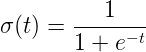

In [ ]:
def sigmoid(z):
    """
    This function counts sigmoid
    Arguments: 
    z -- input value
    
    Returns: 
    the sigmoid activation value for a given input value
    """
    
    return 1 / (1 + np.exp(-z))

The hypothesis for logistic regression then becomes,

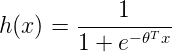

If the weighted sum of inputs is greater than zero, the predicted class is 1 and vice-versa

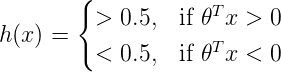

In [ ]:
def lRpredict(X,weight):
    """
    The function checks the values and writes 1 and 0 depending on whether the value is greater than 0.5 or not
    Arguments: 
    X -- The values we want to predict
    weight -- values which we trained  
    
    Returns: 
    an array which contains ones and zerosdient value for a given input values
    """    
    m = np.shape(X)[0]
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    Ypredicted = sigmoid(np.dot(X,weight.T))
    return (Ypredicted>=0.5)*1

Logistic Regression cost function for our model and is: 

And the loss function is given accordingly as follows

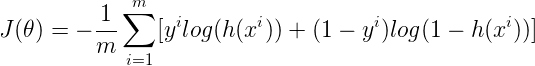

In [ ]:
def lRcost(yTrue,yPredicted,m):
    """
    This function compute costs for Logistical Regression
    Arguments: 
    yTrue -- Labeled value that we had given
    yPredicted -- The value which we have predicted 
    m -- number of samples
    
    Returns: 
    cost value for a given input values
    """
    cost = -1/m*(np.dot(yTrue.T,np.log(yPredicted))+np.dot((1-yTrue).T,np.log(1-yPredicted)))
    return cost

We will use gradient descent to minimize the cost function. The gradient can be given by

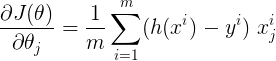

In [ ]:
def lRgradient(X,yTrue,yPredicted):
    """
    This function compute gradient for Logistical Regression
    Arguments: 
    X -- feature matrix
    yTrue -- Labeled value that we had given
    yPredicted -- The value which we have predicted 
    
    Returns: 
    gradient value for a given input values
    """
    m = X.shape[0]
    return (1/m)*np.dot((yPredicted - np.array(yTrue)).T,X)

In [ ]:
def lRmodel(X, y, alpha=0.01, numIterations=1000):
    """
    This function Implement whole Logistic Regression Model
    Arguments:
    X -- feature matrix
    y -- target vector
    alpha -- learning rate (default=0.01)
    numIterations -- maximum number of iterations of the logistic regression algorithm (default=30)
    
    Returns:
    weights, list of the cost function changing overtime
    """
    m = np.shape(X)[0]  # total number of samples
    n = np.shape(X)[1]  # total number of features
    
    # Add bias to our weights, so we have form n + 1 and we also need to add a row to X which will be ones.
    np.random.seed(3)
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    W = np.zeros((1,n + 1))
    
    # stores where we keep all cost Information every 10th iteration
    costHistory = []

    # repeat this procces numIteration times
    for current_iteration in tqdm(range(numIterations)): 

        # compute the dot product between our feature 'X' and weight 'W'
        # then passed the value into our sigmoid activation function
        yPredicted = sigmoid(X.dot(W.T))
        # calculate the cost 
        cost = lRcost(y,yPredicted,m)
        # compute the gradient
        gradient = lRgradient(X,y,yPredicted)
        # Now we have to update our weights
        W = W - alpha * gradient
        
        # append out new cost value in our stores
        costHistory.append(cost[0][0])
    return W,costHistory

In [ ]:
def classification_metrics(yTrueTrain,yPredictTrain,yTrueTest,yPredictTest,heatmap=False)->None:
    """
    this function prints accuracy, precision, recall, F1 scre 
    and create confusion matrix  heatmap for both train and test sets
    
    Arguments:
    yTrueTrain -- the true value of prediction from the train set
    yPredictTrain -- predicted value from the train set
    yTrueTest -- he true value of prediction from the test set
    yPredictTest -- predicted value from the test set
    heatmap -- boolean which tells us if plot heatmap or not
    
    Returns:
    None
    """
    print("train data:\t  "+ "\t"*6+ "test data:\t\n")
    print(("accuracy:\t {0} "+ "\t"*6+ "accuracy:\t {1}").format(accuracy_score(yTrueTrain, yPredictTrain).round(2), 
                                                                 accuracy_score(yTrueTest, yPredictTest).round(2)))
          
    print(("precision:\t {0} "+ "\t"*6+ "precision:\t {1}").format(precision_score(yTrueTrain, yPredictTrain).round(2), 
                                                                   precision_score(yTrueTest, yPredictTest).round(2)))
    
    print(("recall:\t\t {0} "+ "\t"*6+ "recall:\t\t {1}").format(recall_score(yTrueTrain, yPredictTrain).round(2), 
                                                                 recall_score(yTrueTest, yPredictTest).round(2)))
    
    print(("F1:\t\t {0} "+ "\t"*6+ "F1:\t\t {1}").format(f1_score(yTrueTrain, yPredictTrain).round(2), 
                                                         f1_score(yTrueTest, yPredictTest).round(2)))
    if(heatmap):
        f, ax  = plt.subplots(1,2,figsize = (18,6))
        sns.heatmap(confusion_matrix(yTrueTrain,yPredictTrain),cmap='coolwarm',annot=True,ax=ax[0])
        sns.heatmap(confusion_matrix(yTrueTest,yPredictTest),cmap='coolwarm',annot=True,ax=ax[1])
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

> Fit our model and test it

In [ ]:
y_train=np.array(y_train).reshape((y_train.shape[0],1))
weight,costHistory = lRmodel(X_train, y_train, alpha=0.1,numIterations=1500)

testPredict = lRpredict(X_test,weight)
trainPredict = lRpredict(X_train,weight)

classification_metrics(y_train,trainPredict,y_test,testPredict,True)

>It will be good if we look at the cost function and make sure that it decreases

In [ ]:
plt.title("Cost history")
plt.plot(costHistory)

As we have seen the cost function decreases and after 300 iterations it almost no longer changes<br>

### **Feature Engineering** <a  name="12"></a>

as we was [here](#8) some feature may not be correlated to "DEATH_EVENT" so we need to check this, I remove some features and check metrics for this dataframe, here are some features which I will remove <a  name="17"> 

In [ ]:
mayNotImportant = ["diabetes","sex","smoking"]

In [ ]:
metricHistory = []
for col in mayNotImportant:
    X_trainTemp = X_train.copy().drop(columns=col)
    X_testTemp = X_test.copy().drop(columns=col)
    
    weight,costHistory = lRmodel(X_trainTemp, y_train, alpha=0.5,numIterations=1500)

    trainPredict = lRpredict(X_trainTemp,weight)
    testPredict = lRpredict(X_testTemp,weight)
    metricHistory+=[y_train,trainPredict,y_test,testPredict]

#### <div align="center">**model 1 results for dataframe without "diabetes" feature**

In [ ]:
classification_metrics(metricHistory[0],metricHistory[1],metricHistory[2],metricHistory[3],False)

#### <div align="center">**model 2 results for dataframe without "sex" feature**

In [ ]:
classification_metrics(metricHistory[4],metricHistory[5],metricHistory[6],metricHistory[7],False)

#### <div align="center">**model 3 results for dataframe without "smoking" feature**

In [ ]:
classification_metrics(metricHistory[8],metricHistory[9],metricHistory[10],metricHistory[11],False)

notice that we didn't get significant and better.<br>
probably that's why we do not have enough data and we do not notice the difference <br>
but in this example, we need a high recall value because we don't want to have high FalsePositive values<br>
so in these 3 experiments the second example is the best because his recall is 0.81 so we can drop the sex feature<br>
but also I think that dropping data is not good practice. we can try this kind of experiment for all features

>now I try Hyperparameter tuning to improve results

In [ ]:
alpha = [0.01,0.1,0.5]
iteration = [500,1500,5000]

>I am trying to choose alpha value <a  name="18">

In [ ]:
metricHistory = []
for a in alpha:
    X_trainTemp = X_train.copy()
    X_testTemp = X_test.copy()
    
    weight,costHistory = lRmodel(X_trainTemp, y_train, alpha=a)

    trainPredict = lRpredict(X_trainTemp,weight)
    testPredict = lRpredict(X_testTemp,weight)
    metricHistory+=[y_train,trainPredict,y_test,testPredict]

#### <div align="center">**model 1 results for alpha=0.01**

In [ ]:
classification_metrics(metricHistory[0],metricHistory[1],metricHistory[2],metricHistory[3],False)

#### <div align="center">**model 2 results for alpha=0.1**

In [ ]:
classification_metrics(metricHistory[4],metricHistory[5],metricHistory[6],metricHistory[7],False)

#### <div align="center">**model 3 results for alpha=0.5**

In [ ]:
classification_metrics(metricHistory[8],metricHistory[9],metricHistory[10],metricHistory[11],False)

We can see that the results do not differ much<br>
but maybe the third one is the best because there we have high recall

>I am trying to choose number of Iterations

In [ ]:
metricHistory = []
for i in iteration:
    X_trainTemp = X_train.copy()
    X_testTemp = X_test.copy()
    
    weight,costHistory = lRmodel(X_trainTemp, y_train, alpha=0.01,numIterations=i)

    trainPredict = lRpredict(X_trainTemp,weight)
    testPredict = lRpredict(X_testTemp,weight)
    metricHistory+=[y_train,trainPredict,y_test,testPredict]

#### <div align="center">**model 1 results for iterations=500**

In [ ]:
classification_metrics(metricHistory[0],metricHistory[1],metricHistory[2],metricHistory[3],False)

#### <div align="center">**model 2 results for iterations=1500**

In [ ]:
classification_metrics(metricHistory[4],metricHistory[5],metricHistory[6],metricHistory[7],False)

#### <div align="center">**model 3 results for iterations=5000**

In [ ]:
classification_metrics(metricHistory[8],metricHistory[9],metricHistory[10],metricHistory[11],False)

this experiment shows that when we increase number of iterations model overfits the data<br>
because the train result is increases and test results decreases

### **Time** <a  name="19">

this feature is more complex so I separate this<br>

time captures the time of the event. That is, the time at which the patient died or were censored.<br>
I thought thah using the time column as a feature is wrong. <br>

When you deploy your model, no end user will be able to provide you the value of time, since they do not know at what time in the future the patient will die.
so now lets drop this feature and check accuracy

In [ ]:
X_train_wothout_time = X_train.drop(columns="time")
X_test_wothout_time = X_test.drop(columns="time")
y_train=np.array(y_train).reshape((y_train.shape[0],1))

weight,costHistory = lRmodel(X_train_wothout_time, y_train, alpha=0.01,numIterations=1000)

testPredict = lRpredict(X_test_wothout_time,weight)
trainPredict = lRpredict(X_train_wothout_time,weight)

classification_metrics(y_train,trainPredict,y_test,testPredict,True)

we can see that model without "time" feature has lower accuracy but I think this model is more generic<br>
here I write some arguments why we don't need time feature:<br>
- incorrect data by definition
- it has a high correlation to our target and it is not good practice to have a feature with a very high correlation because our model may have fit only these feature

### **New Features** <a  name="13"></a>

>lets create new feature and test them<a  name="20">

In [ ]:
df["creatinine_phosphokinase_squared"] = np.square(df["creatinine_phosphokinase"])
df["age_squared"] = np.square(df["age"])
df["creatinine_phosphokinase_power"] = np.power(df["creatinine_phosphokinase"],3)

features = ['age',"creatinine_phosphokinase","ejection_fraction","platelets",
            "serum_creatinine","serum_sodium","creatinine_phosphokinase_squared",
           "age_squared","creatinine_phosphokinase_power"]

df.drop(columns="time",inplace=True,errors="ignore")
featureNormalization(features)

X = df.drop(columns='DEATH_EVENT')
y = df['DEATH_EVENT']
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.3)

sm = SMOTE()
X_train_s,y_train_s =sm.fit_sample(X_train,y_train)
X_test_s,y_test_s =sm.fit_sample(X_test,y_test)
                                 
X_train = X_train_s
y_train = y_train_s
X_test = X_test_s
y_test = y_test_s
                                 
y_train=np.array(y_train).reshape((y_train.shape[0],1))
weight,costHistory = lRmodel(X_train, y_train, alpha=0.5,numIterations=1500)

testPredict = lRpredict(X_test,weight)
trainPredict = lRpredict(X_train,weight)

classification_metrics(y_train,trainPredict,y_test,testPredict,True)

as we saw this model has almost the same result<br> 
but we were able to get higher recall and The total result left the same<br>
we can try many experiments like this 

# <span style="color:blue"><div align="center">**Summary** <a  name="14"></a>

To sum up.<br> 
Our advice was to predict whether a patient would have a heart attack based on various data.<br>

- First, we studied the data, distributed them one by one.[(see this)](#4)<br>
<br>
- We also looked at features correlations and tried to determine which one contributed to the prediction. [(see this)](#8)<br>
<br>
- and also looked at the connection with the target feature.[(see this)](#15)<br>
<br>
- We did the normalization of the features because the value of some of them was large compared to the others<br> 
and would cause an error in which case the model would only predict 1 or only 0.<br>
We also eliminate the imbalance in our target data to avoid certain errors. [(see this)](#16)<br>
<br>
- We did a logistic regression from 0 and adjusted our data.<br>
We tested it and evaluated its accuracy to see how the cost function was decreasing. [(see this)](#10)<br>
<br>
- Then we tried the algorithm in case we threw away several features<br>
and we saw that throwing one of for example sex, gave us a not so bad result. [(see this)](#17)<br>
<br>
- We tried turning the parameters. We tested different values for alpha and for the number of iterations<br>
we assumed that alpha was the best at 0.5 while the iterations increased as the model went overfit. [(see this)](#18)<br>
<br>
- We also considered a separate "time" feature because it had the greatest impact on the prediction<br> 
and found that it was not very accurate data. [(see this)](#19)<br>
<br>
- We also tried a new feature consisting of the result we could not greatly improve<br>
but increased the recall which is very important in a similar type of examples. [(see this)](#20)<br>